In [1]:
# !if [ -f demo.tar ]; then rm demo.tar; fi
# !if [ -d test_data ]; then rm -rf test_data; fi
# !wget -q https://github.com/AI4EPS/GaMMA/releases/download/test_data/demo.tar
# !tar -xf demo.tar

In [2]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
import multiprocessing as mp

In [3]:
data_path = "test_data/ridgecrest/"
stations = pd.read_csv(os.path.join(data_path, "stations.csv"))
stations["depth_km"] = - stations["elevation_m"] / 1000
stations.iloc[:3]

,station_id,longitude,latitude,elevation_m,depth_km
0,CI.CCC..BH,-117.365,35.525,670.0,-0.67
1,CI.CCC..HH,-117.365,35.525,670.0,-0.67
2,CI.CCC..HN,-117.365,35.525,670.0,-0.67


In [4]:
## Automatic region; you can also specify a region
lon0 = stations["longitude"].median()
lat0 = stations["latitude"].median()

## projection to km
# proj = Proj(f"+proj=sterea +lon_0={lon0} +lat_0={lat0} +k=0.9996 +x_0=0 +y_0=0 +ellps=WGS84 +units=km +no_defs")
proj = Proj(f"+proj=sterea +lon_0={lon0} +lat_0={lat0}  +units=km")
stations[["x_km", "y_km"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
stations["z_km"] = stations["elevation_m"].apply(lambda x: -x/1e3)

xmin = stations["x_km"].min()
xmax = stations["x_km"].max()
ymin = stations["y_km"].min()
ymax = stations["y_km"].max()
x0 = (xmin + xmax) / 2
y0 = (ymin + ymax) / 2

## set up the config; you can also specify the region manually
config = {}
config["xlim_km"] = (2 * xmin - x0, 2 * xmax - x0)
config["ylim_km"] = (2 * ymin - y0, 2 * ymax - y0)
config["zlim_km"] = (stations["z_km"].min(), 20)
zmin = config["zlim_km"][0]
zmax = config["zlim_km"][1]

config["vel"] = {"P": 6.0, "S": 6.0/1.73}

config["bfgs_bounds"] = (
    (config["xlim_km"][0] - 1, config["xlim_km"][1] + 1),  # x
    (config["ylim_km"][0] - 1, config["ylim_km"][1] + 1),  # y
    # (config["zlim_km"][0], config["zlim_km"][1] + 1),  # z
    (0, config["zlim_km"][1] + 1),
    (None, None),  # t
)

mapping_phase_type_int = {"P": 0, "S": 1}
config["vel"] = {mapping_phase_type_int[k]: v for k, v in config["vel"].items()}


Text(0.5, 1.0, 'Stations')

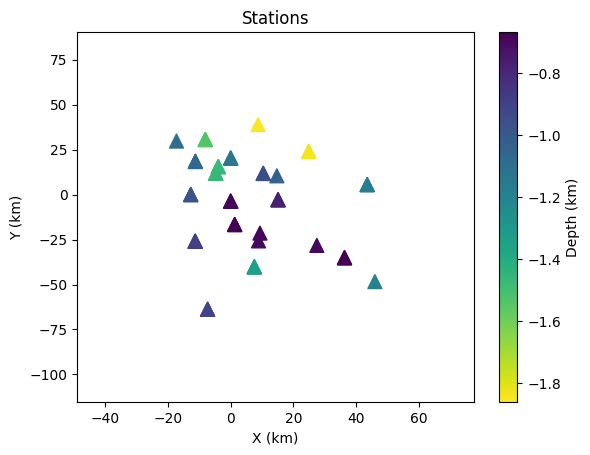

In [5]:
plt.figure()
plt.scatter(stations["x_km"], stations["y_km"], c=stations["depth_km"], cmap="viridis_r", s=100, marker="^")
plt.colorbar(label="Depth (km)")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.xlim(config["xlim_km"])
plt.ylim(config["ylim_km"])
plt.title("Stations")

In [6]:
data_path = "results/ridgecrest/"
picks = pd.read_csv(os.path.join(data_path, "gamma_picks.csv"), parse_dates=["phase_time"])
events = pd.read_csv(os.path.join(data_path, "gamma_events.csv"), parse_dates=["time"])


In [7]:
picks.iloc[:3]

,station_id,phase_time,phase_score,phase_amplitude,phase_type,event_index,gamma_score
0,CI.CCC..BH,2019-07-04 22:00:06.084,0.939738,0.000017,P,975,0.2442
1,CI.CCC..BH,2019-07-04 22:00:31.934,0.953992,0.000006,P,978,0.2442
2,CI.CCC..BH,2019-07-04 22:00:38.834,0.837302,0.000006,P,980,0.2442


In [8]:
events.iloc[:3]

,time,magnitude,sigma_time,sigma_amp,cov_time_amp,gamma_score,num_picks,num_p_picks,num_s_picks,event_index,x(km),y(km),z(km),longitude,latitude,depth_km
0,2019-07-04 22:29:35.263,1.399,0.759,0.519,0.101,70.977,71,31,40,0,25.259,-16.811,7.150,-117.486,35.690,7.150
1,2019-07-04 20:59:58.518,1.187,1.775,0.402,0.100,54.643,55,27,28,29,25.720,-15.884,9.614,-117.481,35.699,9.614
2,2019-07-04 21:00:09.438,1.664,0.457,0.379,-0.011,89.929,90,45,45,30,19.169,-23.087,10.625,-117.553,35.634,10.625


In [9]:
from adloc.eikonal2d import eikonal_solve
from adloc.sacloc2d import ADLoc
from adloc import RANSACRegressor
import numpy as np

In [10]:
def init_eikonal2d(config):

    rlim = [0, np.sqrt((config["xlim_km"][1] - config["xlim_km"][0]) ** 2 + (config["ylim_km"][1] - config["ylim_km"][0]) ** 2)]
    zlim = config["zlim_km"]
    h = config["h"]

    rgrid = np.arange(rlim[0], rlim[1] + h, h)
    zgrid = np.arange(zlim[0], zlim[1] + h, h)
    nr = len(rgrid)
    nz = len(zgrid)

    vel = config["vel"]
    zz, vp, vs = vel["Z"], vel["P"], vel["S"]
    vp1d = np.interp(zgrid, zz, vp)
    vs1d = np.interp(zgrid, zz, vs)
    vp = np.tile(vp1d, (nr, 1))
    vs = np.tile(vs1d, (nr, 1))

    up = 1000 * np.ones((nr, nz))
    up[0, 0] = 0.0

    up = eikonal_solve(up, vp, h)
    grad_up = np.gradient(up, h, edge_order=2)
    up = up.ravel()
    grad_up = [x.ravel() for x in grad_up]

    us = 1000 * np.ones((nr, nz))
    us[0, 0] = 0.0

    us = eikonal_solve(us, vs, h)
    grad_us = np.gradient(us, h, edge_order=2)
    us = us.ravel()
    grad_us = [x.ravel() for x in grad_us]

    config.update(
        {
            "up": up,
            "us": us,
            "grad_up": grad_up,
            "grad_us": grad_us,
            "rgrid": rgrid,
            "zgrid": zgrid,
            "nr": nr,
            "nz": nz,
            "h": h
        }
    )

    return config

In [11]:
## Eikonal for 1D velocity model
zz = [0.0, 5.5, 16.0, 32.0]
vp = [5.5, 5.5,  6.7,  7.8]
vp_vs_ratio = 1.73
vs = [v / vp_vs_ratio for v in vp]
h = 0.3
vel = {"Z": zz, "P": vp, "S": vs}
config["eikonal"] = {"vel": vel, "h": h, "xlim_km": config["xlim_km"], "ylim_km": config["ylim_km"], "zlim_km": config["zlim_km"]}
config["eikonal"] = init_eikonal2d(config["eikonal"])


Eikonal Solver: 
Iter 0, error = 999.945
Iter 1, error = 0.000
Time: 3.356
Eikonal Solver: 
Iter 0, error = 999.906
Iter 1, error = 0.000
Time: 0.058


In [12]:
stations["station_term_s"] = 0.0

In [13]:
# %%
stations["idx_sta"] = stations.index  # reindex in case the index does not start from 0 or is not continuous

events["idx_eve"] = events.index  # reindex in case the index does not start from 0 or is not continuous

picks = picks.merge(events[["event_index", "idx_eve"]], on="event_index")

picks = picks.merge(stations[["station_id", "idx_sta"]], on="station_id")

In [14]:
# %% backup old events
events_old = events.copy()
events_old[["x_km", "y_km"]] = events_old.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
events_old["z_km"] = events["depth_km"]

In [15]:
## Location using ADLoc
# MIN_ADLOC_SCORE = 0.95
MIN_PICKS = 4
MIN_PICKS_RATIO = 0.2
MAX_RESIDUAL_S = 1.0
MIN_SCORE = 0.9
METHOD = "RANSAC"

def is_model_valid(estimator, X, y):
    score = estimator.score(X, y)
    return score > MIN_SCORE

def is_data_valid(X, y):
    """
    X: idx_sta, type, score
    y: t_s
    """
    # At least 2 P and S picks
    n0 = np.sum(X[:, 1] == 0)
    n1 = np.sum(X[:, 1] == 1)
    return n0 >= 2 and n1 >= 2


estimator = ADLoc(config, stations=stations[["x_km", "y_km", "z_km"]].values, eikonal=config["eikonal"])
event_init = np.array([[np.mean(config["xlim_km"]), np.mean(config["ylim_km"]), np.mean(config["zlim_km"]), 0.0]])


def calc_location(event_index, picks_by_event, estimator, events, mask_idx, picks_mask, error_idx, error_s, lock):

    X = picks_by_event.merge(
        stations[["x_km", "y_km", "z_km", "station_id", "station_term_s"]],
        on="station_id",
    )
    event_init = np.array([[np.median(X["x_km"]), np.median(X["y_km"]), np.mean(config["zlim_km"]), 0.0]])
    xstd = np.std(X["x_km"])
    ystd = np.std(X["y_km"])
    rstd = np.sqrt(xstd ** 2 + ystd ** 2)
    
    t0 = X["phase_time"].min()
    X.rename(columns={"phase_type": "type", "phase_score": "score", "phase_time": "t_s"}, inplace=True)
    X["t_s"] = (X["t_s"] - t0).dt.total_seconds()
    X["t_s"] = X["t_s"] - X["station_term_s"]
    X = X[["idx_sta", "type", "score", "t_s", ]]
    X["type"] = X["type"].apply(lambda x: mapping_phase_type_int[x])

    estimator.set_params(**{"events": event_init})
    # ## Location using ADLoc
    # estimator.fit(X[["idx_sta", "type", "score"]].values, y=X["t_s"].values)
    # mask = np.ones(len(picks_by_event)).astype(bool)

    ## Location using RANSAC
    num_picks = len(picks_by_event)
    reg = RANSACRegressor(
        estimator=estimator,
        random_state=0,
        min_samples=max(MIN_PICKS, int(MIN_PICKS_RATIO * num_picks)),
        # residual_threshold=min(2.0, MAX_RESIDUAL_S/np.exp(-(num_picks-4.0)/50)), # larger threshold for more picks
        residual_threshold=MAX_RESIDUAL_S * (1.0 - np.exp(-rstd/60.0)), # not sure which one is better
        is_model_valid=is_model_valid,
        is_data_valid=is_data_valid,
    )
    try:
        reg.fit(X[["idx_sta", "type", "score"]].values, X["t_s"].values)
    except:
        return f"No valid model for event {event_index}"
    estimator = reg.estimator_
    mask = reg.inlier_mask_

    ## Predict travel time    
    tt = estimator.predict(X[["idx_sta", "type"]].values)

    if np.sum(mask) > MIN_PICKS:
        score = estimator.score(X[["idx_sta", "type", "score"]].values[mask], y=X["t_s"].values[mask])
        mean_residual_s = np.sum(np.abs(X["t_s"].values - tt) * mask) / np.sum(mask)
        x,y,z,t = estimator.events[0]
        events.append([event_index, x, y, z, t0 + pd.Timedelta(t, unit="s"), score, mean_residual_s, np.sum(mask)])
        mask_idx_ = picks_by_event.index.values
        picks_mask_ = mask.astype(int)
        # mask_idx.extend(picks_by_event.index.values)
        # picks_mask.extend(mask.astype(int))
    else:
        mask_idx_ = picks_by_event.index.values
        picks_mask_ = np.zeros(len(picks_by_event), dtype=int)
        # mask_idx.extend(picks_by_event.index.values)
        # picks_mask.extend(np.zeros(len(picks_by_event), dtype=int))

    with lock:
        error_idx.extend(picks_by_event.index.values)
        error_s.extend(X["t_s"].values - tt)
        mask_idx.extend(mask_idx_)
        picks_mask.extend(picks_mask_)

  3%|▎         | 37/1390 [00:04<00:44, 30.34it/s] 

No valid model for event 23


  9%|▊         | 120/1390 [00:08<00:55, 22.87it/s]

No valid model for event 108


 12%|█▏        | 169/1390 [00:10<00:43, 27.80it/s]

No valid model for event 148


 18%|█▊        | 251/1390 [00:13<00:35, 32.19it/s]

No valid model for event 232


 23%|██▎       | 325/1390 [00:16<00:51, 20.53it/s]

No valid model for event 315


 29%|██▊       | 399/1390 [00:18<00:30, 32.99it/s]

No valid model for event 380


 36%|███▌      | 499/1390 [00:22<00:41, 21.31it/s]

No valid model for event 492


 37%|███▋      | 509/1390 [00:22<00:28, 30.85it/s]

No valid model for event 501


 43%|████▎     | 602/1390 [00:26<00:32, 24.20it/s]

No valid model for event 591


 46%|████▌     | 638/1390 [00:27<00:18, 40.62it/s]

No valid model for event 627


 47%|████▋     | 659/1390 [00:27<00:25, 28.71it/s]

No valid model for event 642


 51%|█████     | 707/1390 [00:29<00:20, 33.40it/s]

No valid model for event 682


 59%|█████▊    | 815/1390 [00:33<00:16, 34.72it/s]

No valid model for event 789


 69%|██████▉   | 964/1390 [00:38<00:18, 23.35it/s]

No valid model for event 955


 75%|███████▍  | 1040/1390 [00:41<00:13, 25.60it/s]

No valid model for event 1024


 83%|████████▎ | 1150/1390 [00:46<00:08, 28.57it/s]

No valid model for event 1136


 86%|████████▌ | 1191/1390 [00:47<00:07, 27.32it/s]

No valid model for event 1173


 93%|█████████▎| 1290/1390 [00:51<00:03, 25.97it/s]

No valid model for event 1274


 98%|█████████▊| 1365/1390 [00:54<00:01, 20.72it/s]

No valid model for event 1352


100%|██████████| 1390/1390 [01:19<00:00, 17.46it/s]


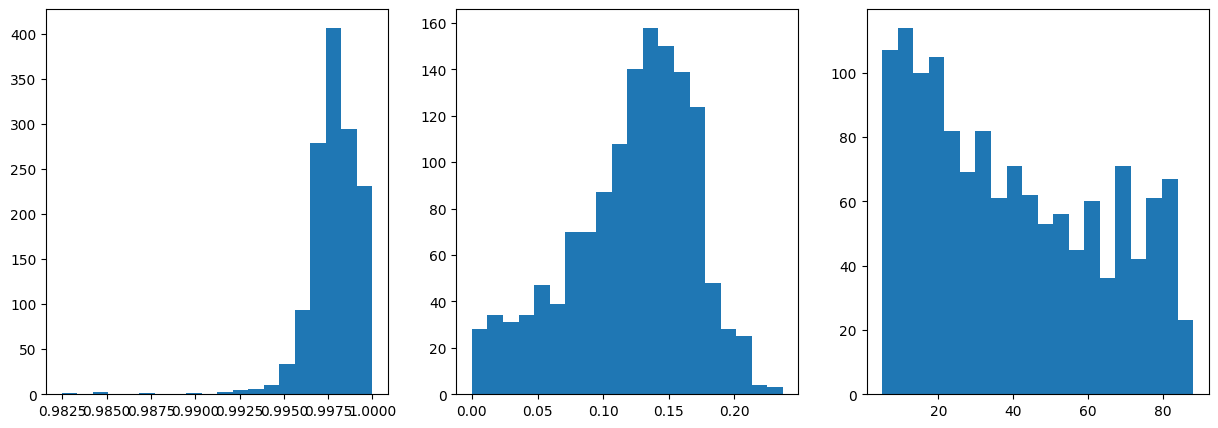

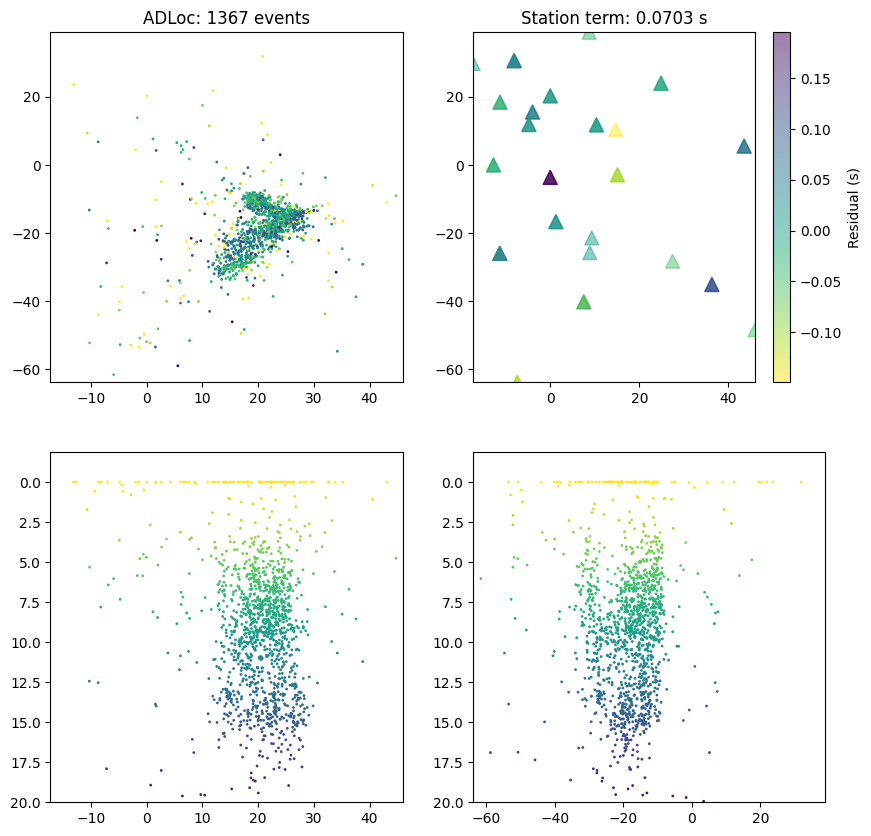

  4%|▎         | 52/1390 [00:05<00:46, 28.49it/s] 

No valid model for event 23


  9%|▉         | 127/1390 [00:08<00:40, 31.55it/s]

No valid model for event 108


 12%|█▏        | 169/1390 [00:09<00:37, 32.25it/s]

No valid model for event 148


 19%|█▉        | 262/1390 [00:11<00:27, 40.84it/s]

No valid model for event 232


 24%|██▍       | 335/1390 [00:14<00:30, 34.37it/s]

No valid model for event 315


 28%|██▊       | 393/1390 [00:15<00:23, 42.70it/s]

No valid model for event 380


 37%|███▋      | 509/1390 [00:19<00:25, 34.24it/s]

No valid model for event 492
No valid model for event 501


 44%|████▎     | 605/1390 [00:21<00:28, 27.27it/s]

No valid model for event 591


 46%|████▌     | 640/1390 [00:22<00:18, 41.06it/s]

No valid model for event 627


 48%|████▊     | 666/1390 [00:23<00:17, 40.49it/s]

No valid model for event 642


 50%|█████     | 699/1390 [00:24<00:19, 34.61it/s]

No valid model for event 682


 59%|█████▉    | 819/1390 [00:28<00:15, 37.87it/s]

No valid model for event 789


 70%|███████   | 977/1390 [00:32<00:13, 31.56it/s]

No valid model for event 955


 75%|███████▌  | 1049/1390 [00:34<00:12, 27.89it/s]

No valid model for event 1024


 83%|████████▎ | 1158/1390 [00:38<00:08, 28.89it/s]

No valid model for event 1136


 86%|████████▋ | 1200/1390 [00:39<00:05, 35.86it/s]

No valid model for event 1173


 92%|█████████▏| 1282/1390 [00:42<00:03, 30.21it/s]

No valid model for event 1274


 98%|█████████▊| 1368/1390 [00:44<00:00, 34.65it/s]

No valid model for event 1352


100%|██████████| 1390/1390 [01:09<00:00, 20.13it/s]


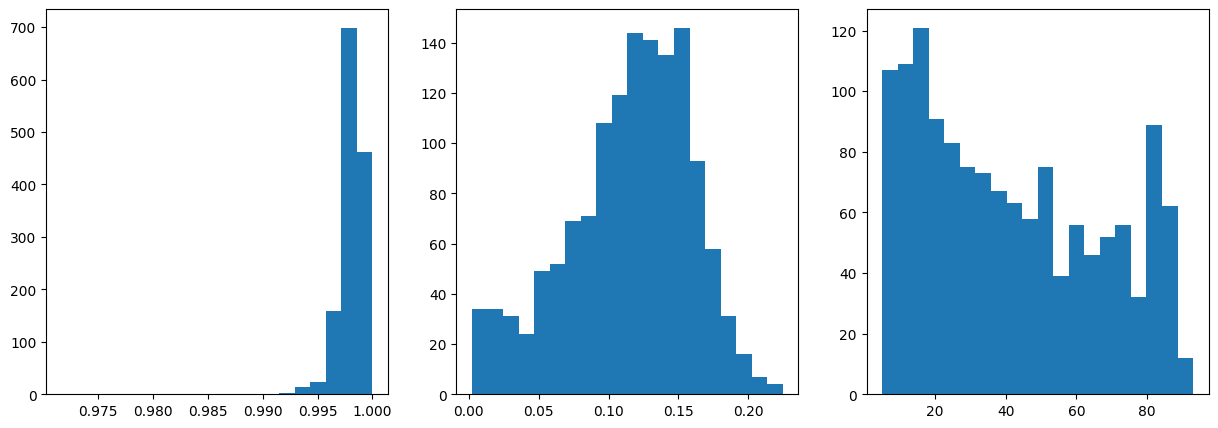

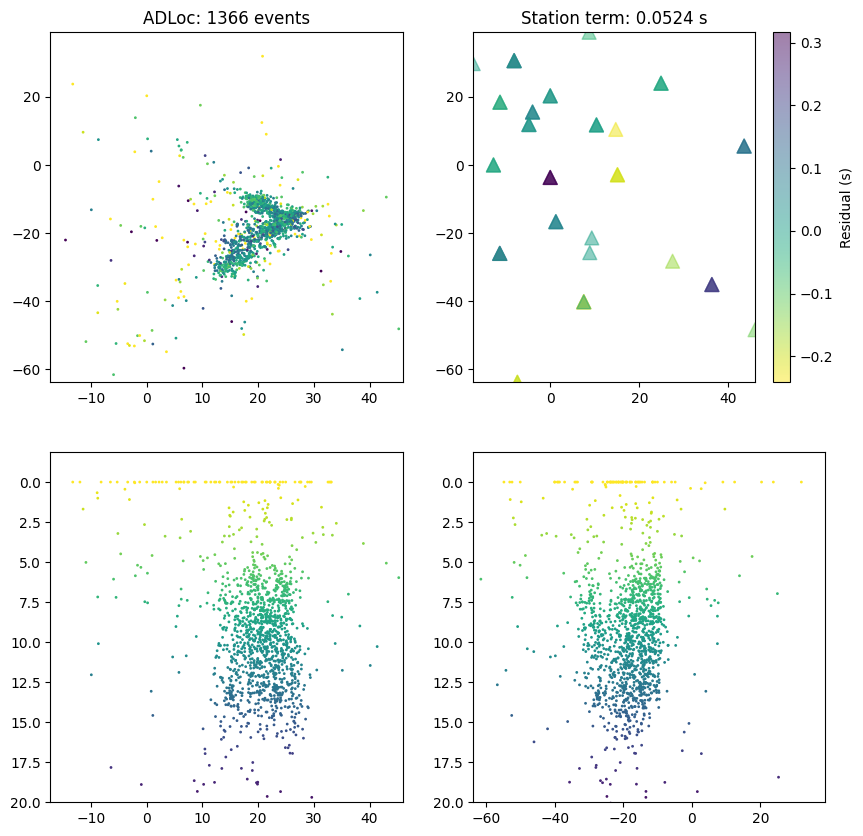

  3%|▎         | 47/1390 [00:05<00:49, 26.94it/s] 

No valid model for event 23


 10%|▉         | 138/1390 [00:07<00:30, 41.28it/s]

No valid model for event 108


 13%|█▎        | 180/1390 [00:08<00:26, 45.82it/s]

No valid model for event 148


 18%|█▊        | 248/1390 [00:10<00:22, 50.88it/s]

No valid model for event 232


 25%|██▍       | 346/1390 [00:12<00:24, 43.32it/s]

No valid model for event 315


 28%|██▊       | 388/1390 [00:13<00:22, 43.91it/s]

No valid model for event 380


 38%|███▊      | 530/1390 [00:17<00:16, 52.04it/s]

No valid model for event 492
No valid model for event 501


 44%|████▍     | 612/1390 [00:19<00:20, 37.05it/s]

No valid model for event 591


 46%|████▌     | 637/1390 [00:19<00:14, 52.26it/s]

No valid model for event 627


 48%|████▊     | 661/1390 [00:20<00:14, 51.17it/s]

No valid model for event 642


 50%|█████     | 699/1390 [00:21<00:15, 45.47it/s]

No valid model for event 682


 60%|██████    | 835/1390 [00:24<00:11, 47.75it/s]

No valid model for event 789


 71%|███████   | 987/1390 [00:28<00:13, 30.46it/s]

No valid model for event 955


 76%|███████▌  | 1053/1390 [00:30<00:09, 34.56it/s]

No valid model for event 1024


 83%|████████▎ | 1150/1390 [00:32<00:05, 44.08it/s]

No valid model for event 1136


 86%|████████▋ | 1202/1390 [00:34<00:04, 40.91it/s]

No valid model for event 1173


 92%|█████████▏| 1285/1390 [00:36<00:02, 39.81it/s]

No valid model for event 1274


 98%|█████████▊| 1367/1390 [00:38<00:00, 39.93it/s]

No valid model for event 1352


100%|██████████| 1390/1390 [01:03<00:00, 21.97it/s]


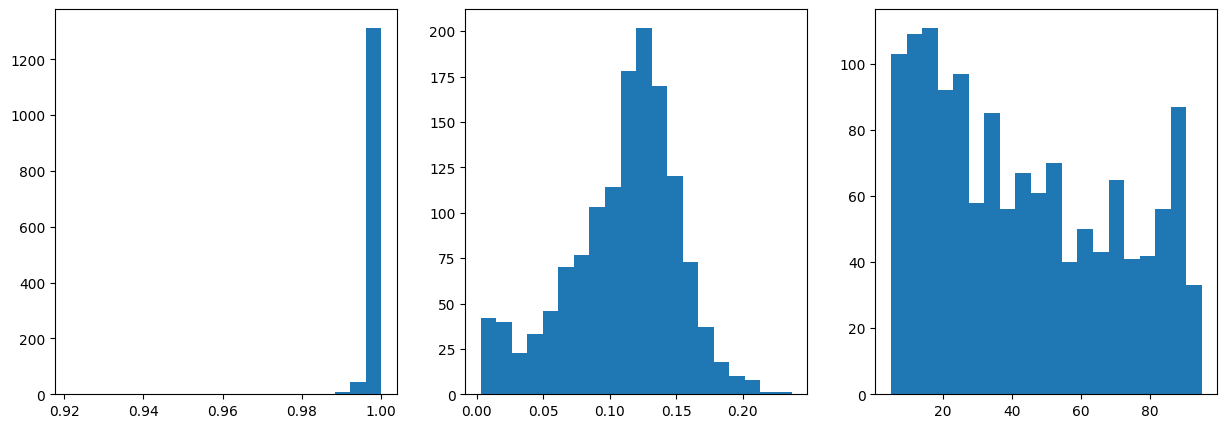

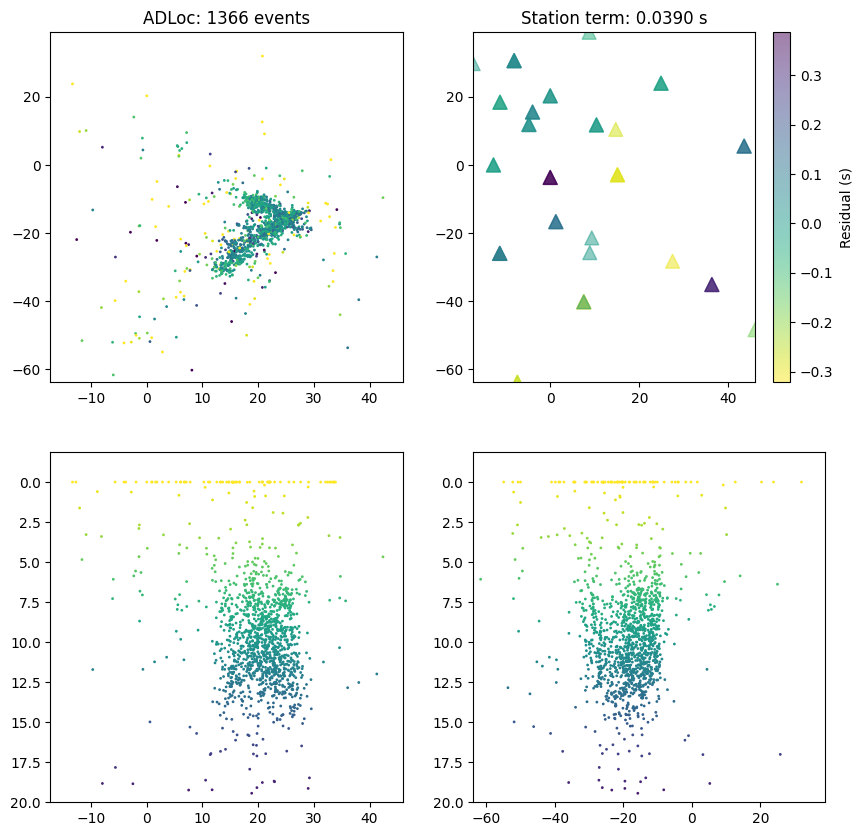

  4%|▍         | 58/1390 [00:05<00:37, 35.70it/s] 

No valid model for event 23


  9%|▊         | 121/1390 [00:07<00:30, 41.03it/s]

No valid model for event 108


 13%|█▎        | 182/1390 [00:08<00:26, 46.30it/s]

No valid model for event 148


 18%|█▊        | 254/1390 [00:09<00:21, 52.43it/s]

No valid model for event 232


 25%|██▍       | 347/1390 [00:12<00:21, 47.48it/s]

No valid model for event 315


 28%|██▊       | 392/1390 [00:13<00:20, 47.66it/s]

No valid model for event 380


 39%|███▊      | 538/1390 [00:16<00:15, 53.77it/s]

No valid model for event 492
No valid model for event 501


 44%|████▍     | 613/1390 [00:18<00:19, 40.59it/s]

No valid model for event 591


 46%|████▌     | 637/1390 [00:18<00:13, 55.03it/s]

No valid model for event 627


 48%|████▊     | 663/1390 [00:18<00:13, 53.26it/s]

No valid model for event 642


 51%|█████     | 707/1390 [00:19<00:14, 46.09it/s]

No valid model for event 682


 60%|██████    | 836/1390 [00:23<00:11, 48.71it/s]

No valid model for event 789


 71%|███████   | 990/1390 [00:26<00:10, 39.05it/s]

No valid model for event 955


 76%|███████▌  | 1055/1390 [00:28<00:08, 41.54it/s]

No valid model for event 1024


 84%|████████▍ | 1167/1390 [00:31<00:05, 41.62it/s]

No valid model for event 1136


 87%|████████▋ | 1204/1390 [00:31<00:04, 41.92it/s]

No valid model for event 1173


 93%|█████████▎| 1287/1390 [00:33<00:02, 44.56it/s]

No valid model for event 1274


 99%|█████████▊| 1372/1390 [00:35<00:00, 40.86it/s]

No valid model for event 1352


100%|██████████| 1390/1390 [01:01<00:00, 22.74it/s]


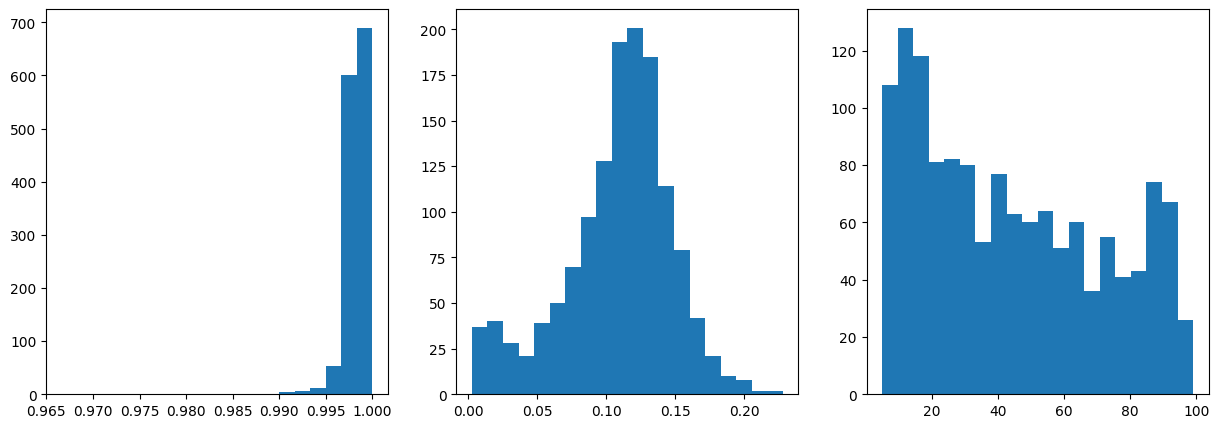

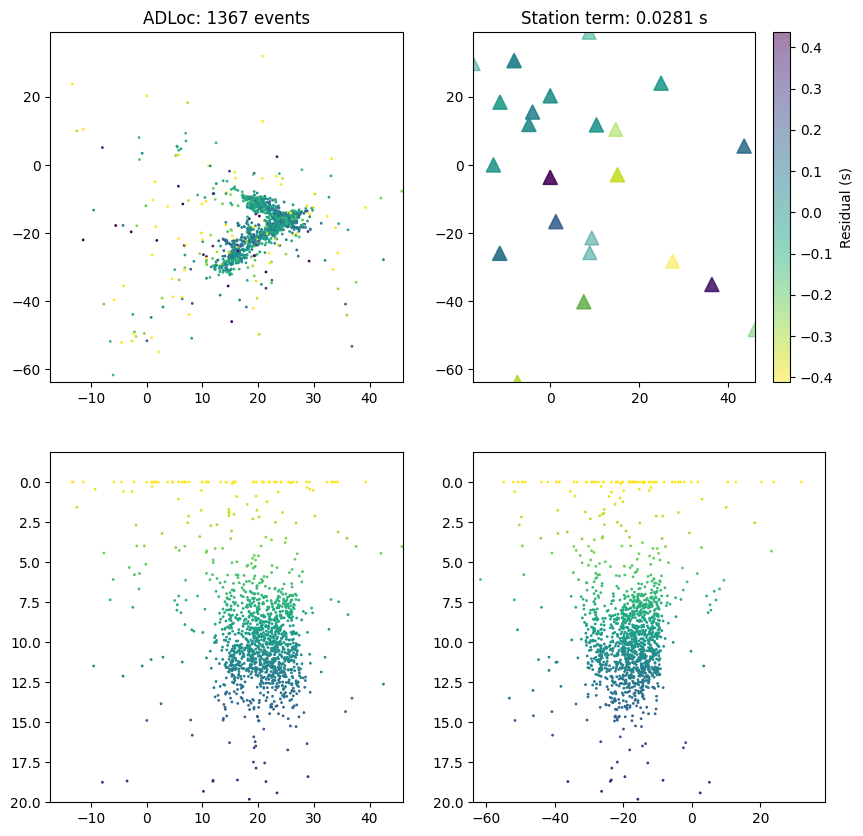

  3%|▎         | 42/1390 [00:04<00:55, 24.39it/s] 

No valid model for event 23


  8%|▊         | 116/1390 [00:06<00:25, 49.58it/s]

No valid model for event 108


 13%|█▎        | 186/1390 [00:08<00:26, 45.79it/s]

No valid model for event 148


 19%|█▊        | 260/1390 [00:09<00:22, 49.86it/s]

No valid model for event 232


 25%|██▍       | 347/1390 [00:11<00:21, 48.72it/s]

No valid model for event 315


 28%|██▊       | 394/1390 [00:12<00:18, 53.82it/s]

No valid model for event 380


 38%|███▊      | 534/1390 [00:15<00:16, 50.91it/s]

No valid model for event 492


 39%|███▉      | 543/1390 [00:15<00:15, 55.72it/s]

No valid model for event 501


 45%|████▌     | 631/1390 [00:17<00:12, 59.09it/s]

No valid model for event 591
No valid model for event 627


 47%|████▋     | 653/1390 [00:17<00:11, 62.81it/s]

No valid model for event 642


 51%|█████     | 705/1390 [00:19<00:15, 45.48it/s]

No valid model for event 682


 61%|██████    | 848/1390 [00:22<00:10, 52.86it/s]

No valid model for event 789


 71%|███████▏  | 993/1390 [00:25<00:09, 41.09it/s]

No valid model for event 955


 75%|███████▍  | 1040/1390 [00:26<00:07, 46.63it/s]

No valid model for event 1024


 83%|████████▎ | 1159/1390 [00:29<00:05, 41.88it/s]

No valid model for event 1136


 87%|████████▋ | 1203/1390 [00:30<00:04, 37.69it/s]

No valid model for event 1173


 93%|█████████▎| 1291/1390 [00:32<00:02, 43.46it/s]

No valid model for event 1274


 99%|█████████▉| 1375/1390 [00:34<00:00, 41.84it/s]

No valid model for event 1352


100%|██████████| 1390/1390 [00:59<00:00, 23.26it/s]


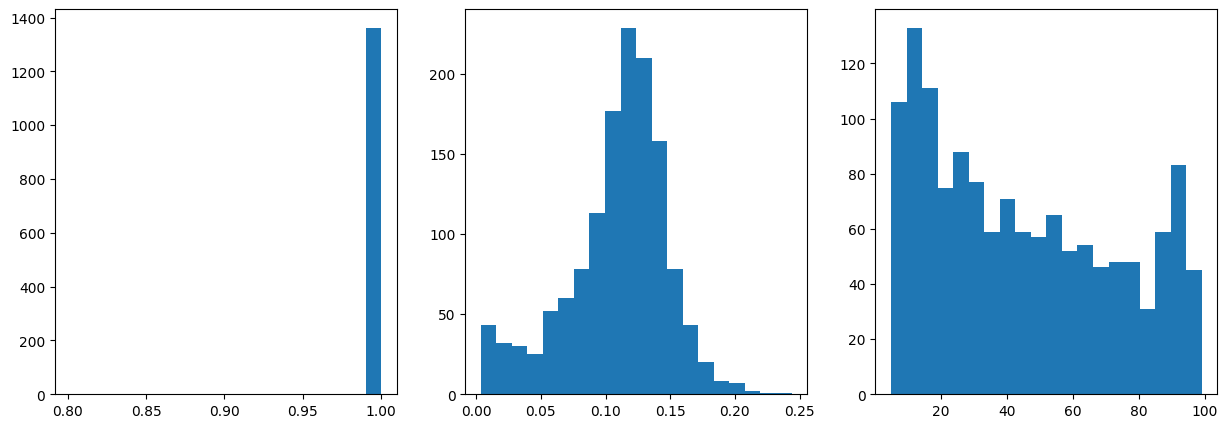

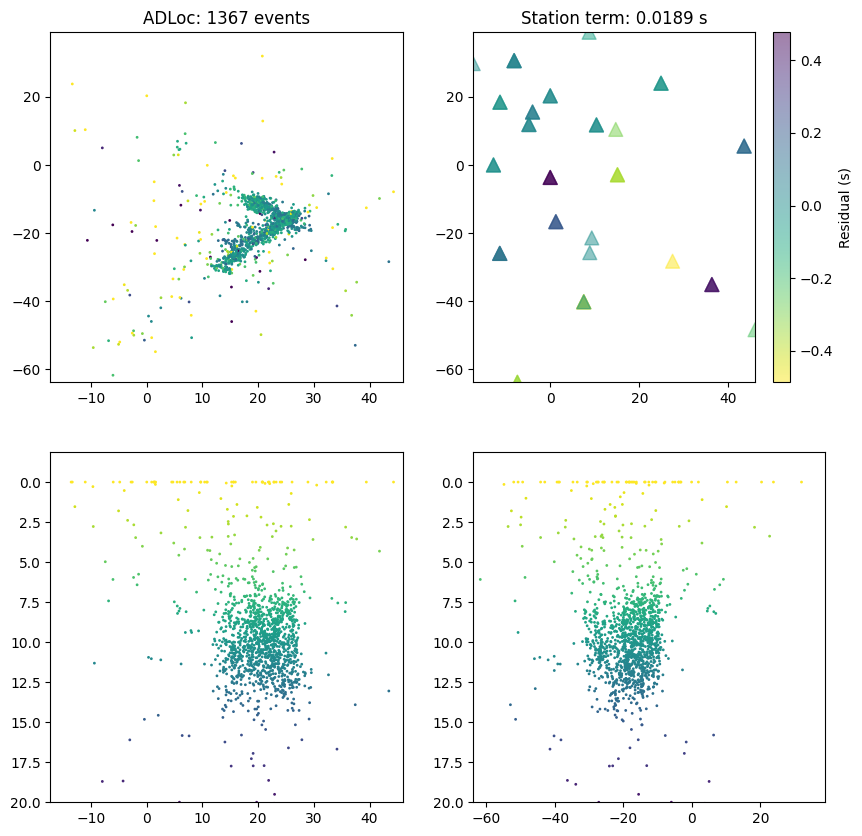

  4%|▍         | 53/1390 [00:05<00:44, 30.06it/s] 

No valid model for event 23


  9%|▊         | 119/1390 [00:06<00:24, 51.86it/s]

No valid model for event 108


 14%|█▎        | 188/1390 [00:07<00:28, 41.86it/s]

No valid model for event 148


 19%|█▉        | 265/1390 [00:09<00:27, 40.58it/s]

No valid model for event 232


 24%|██▍       | 339/1390 [00:11<00:23, 43.87it/s]

No valid model for event 315


 28%|██▊       | 391/1390 [00:12<00:18, 55.26it/s]

No valid model for event 380


 38%|███▊      | 529/1390 [00:15<00:17, 48.08it/s]

No valid model for event 492
No valid model for event 501


 45%|████▍     | 624/1390 [00:17<00:13, 56.21it/s]

No valid model for event 591


 46%|████▌     | 638/1390 [00:17<00:13, 55.46it/s]

No valid model for event 627


 47%|████▋     | 656/1390 [00:17<00:12, 59.89it/s]

No valid model for event 642


 51%|█████     | 702/1390 [00:18<00:15, 45.37it/s]

No valid model for event 682


 60%|██████    | 837/1390 [00:21<00:09, 55.51it/s]

No valid model for event 789


 72%|███████▏  | 998/1390 [00:25<00:09, 39.43it/s]

No valid model for event 955


 75%|███████▍  | 1042/1390 [00:26<00:06, 51.18it/s]

No valid model for event 1024


 84%|████████▎ | 1162/1390 [00:29<00:05, 44.74it/s]

No valid model for event 1136


 87%|████████▋ | 1203/1390 [00:30<00:04, 41.73it/s]

No valid model for event 1173


 92%|█████████▏| 1285/1390 [00:32<00:02, 51.16it/s]

No valid model for event 1274


 99%|█████████▉| 1373/1390 [00:34<00:00, 45.13it/s]

No valid model for event 1352


100%|██████████| 1390/1390 [00:59<00:00, 23.30it/s]


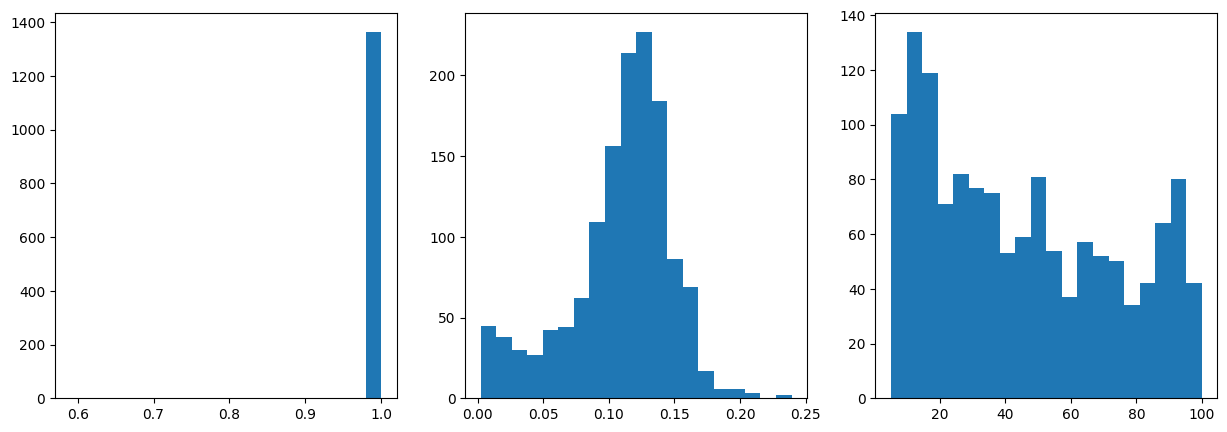

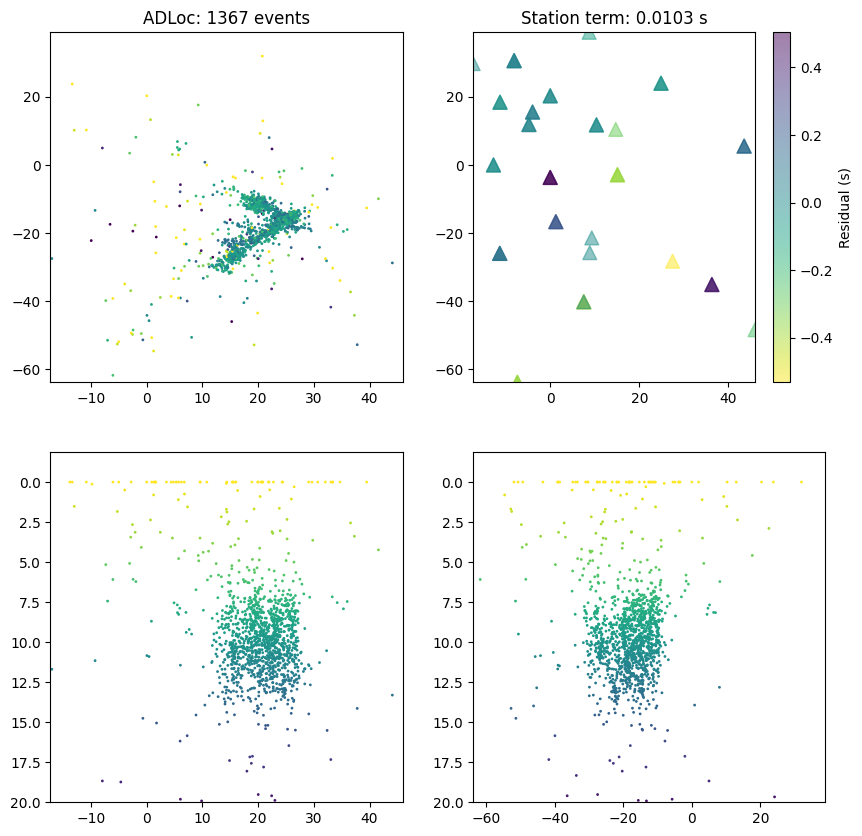

  4%|▍         | 54/1390 [00:04<00:36, 36.82it/s] 

No valid model for event 23


  9%|▊         | 121/1390 [00:06<00:25, 50.64it/s]

No valid model for event 108


 13%|█▎        | 186/1390 [00:07<00:26, 46.10it/s]

No valid model for event 148


 19%|█▉        | 267/1390 [00:09<00:24, 46.61it/s]

No valid model for event 232


 24%|██▍       | 340/1390 [00:11<00:24, 43.71it/s]

No valid model for event 315


 28%|██▊       | 387/1390 [00:11<00:17, 58.13it/s]

No valid model for event 380


 38%|███▊      | 528/1390 [00:14<00:18, 47.58it/s]

No valid model for event 492
No valid model for event 501


 45%|████▌     | 626/1390 [00:16<00:13, 54.95it/s]

No valid model for event 591
No valid model for event 627


 47%|████▋     | 653/1390 [00:17<00:13, 56.37it/s]

No valid model for event 642


 50%|█████     | 698/1390 [00:18<00:16, 41.73it/s]

No valid model for event 682


 60%|██████    | 838/1390 [00:21<00:09, 56.02it/s]

No valid model for event 789


 71%|███████▏  | 993/1390 [00:24<00:08, 44.80it/s]

No valid model for event 955


 75%|███████▍  | 1040/1390 [00:25<00:07, 44.53it/s]

No valid model for event 1024


 83%|████████▎ | 1159/1390 [00:28<00:05, 40.75it/s]

No valid model for event 1136


 87%|████████▋ | 1205/1390 [00:29<00:04, 42.93it/s]

No valid model for event 1173


 92%|█████████▏| 1285/1390 [00:31<00:02, 49.31it/s]

No valid model for event 1274


 98%|█████████▊| 1369/1390 [00:33<00:00, 39.14it/s]

No valid model for event 1352


100%|██████████| 1390/1390 [00:58<00:00, 23.85it/s]

Mean station term: 0.0063866442432012225


In [16]:
NCPU = mp.cpu_count()
MAX_SST_ITER = 10
MIN_SST_S = 0.01
num_iter = 0
while num_iter < MAX_SST_ITER:

    with mp.Manager() as manager:
        mask_idx = manager.list()
        mask = manager.list()
        error_idx = manager.list()
        error_s = manager.list()
        locations = manager.list()
        lock = manager.Lock()
        pbar = tqdm(total=len(picks.groupby("idx_eve")))
        threads = []
        with mp.get_context("fork").Pool(NCPU) as pool:
            for event_index, picks_by_event in picks.groupby("idx_eve"):
                thread = pool.apply_async(calc_location, args=(event_index, picks_by_event, estimator, locations, mask_idx, mask, error_idx, error_s, lock), callback=lambda x: pbar.update())
                threads.append(thread)
            for thread in threads:
                out = thread.get()
                if out is not None:
                    print(out)
        mask_idx = list(mask_idx)
        mask = list(mask)
        error_idx = list(error_idx)
        error_s = list(error_s)
        locations = list(locations)
        pbar.close()


    picks.loc[mask_idx, "mask"] = mask
    picks.loc[error_idx, "residual_s"] = error_s
    locations = pd.DataFrame(locations, columns=["idx_eve", "x_km", "y_km", "z_km", "time", "adloc_score", "adloc_residual_s", "num_picks"])
    locations = locations.merge(events[["event_index", "idx_eve"]], on="idx_eve")
    
    station_term = picks[picks["mask"] == 1.0].groupby("idx_sta").agg({"residual_s": "mean"}).reset_index()
    stations['station_term_s'] += stations['idx_sta'].map(station_term.set_index('idx_sta')['residual_s']).fillna(0)

    if np.mean(np.abs(station_term["residual_s"])) < MIN_SST_S:
        print(f"Mean station term: {np.mean(np.abs(station_term['residual_s']))}")
        break
    num_iter += 1

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.hist(locations["adloc_score"], bins=20) 
    plt.subplot(132)
    plt.hist(locations["adloc_residual_s"], bins=20)
    plt.subplot(133)
    plt.hist(locations["num_picks"], bins=20)
    plt.show()

    vmin = min(locations["z_km"].min(), events_old["depth_km"].min())
    vmax = max(locations["z_km"].max(), events_old["depth_km"].max())

    plt.figure(figsize=(10, 10))
    plt.subplot(221)
    plt.scatter(locations["x_km"], locations["y_km"], c=locations["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.title(f"ADLoc: {len(locations)} events")

    plt.subplot(222)
    plt.scatter(stations["x_km"], stations["y_km"], c=stations["station_term_s"], cmap="viridis_r", s=100, marker="^", alpha=0.5)
    plt.colorbar(label="Residual (s)")
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.title(f"Station term: {np.mean(np.abs(station_term['residual_s'])):.4f} s")

    plt.subplot(223)
    plt.scatter(locations["x_km"], locations["z_km"], c=locations["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
    plt.xlim([xmin, xmax])
    plt.ylim([zmax, zmin])

    plt.subplot(224)
    plt.scatter(locations["y_km"], locations["z_km"], c=locations["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
    plt.xlim([ymin, ymax])
    plt.ylim([zmax, zmin])

    plt.show()


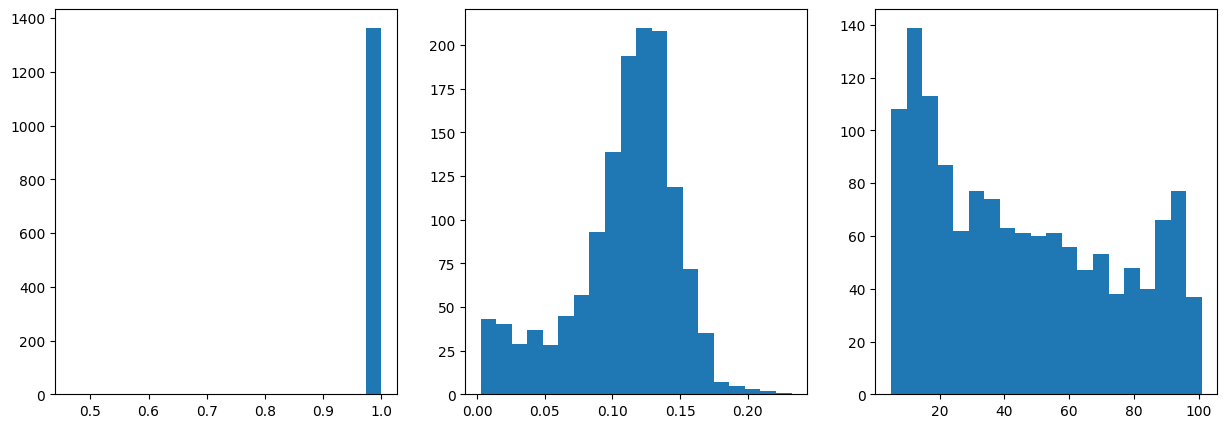

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.hist(locations["adloc_score"], bins=20) 
plt.subplot(132)
plt.hist(locations["adloc_residual_s"], bins=20)
plt.subplot(133)
plt.hist(locations["num_picks"], bins=20)
plt.show()
# location = locations[locations["num_picks"] > 20]

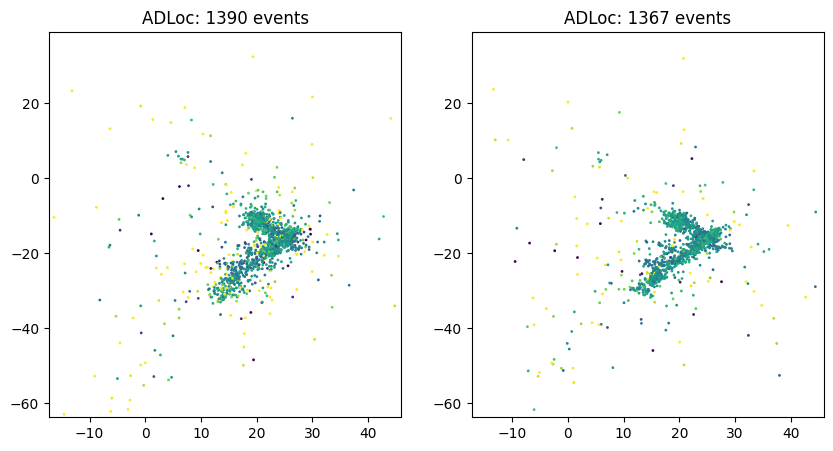

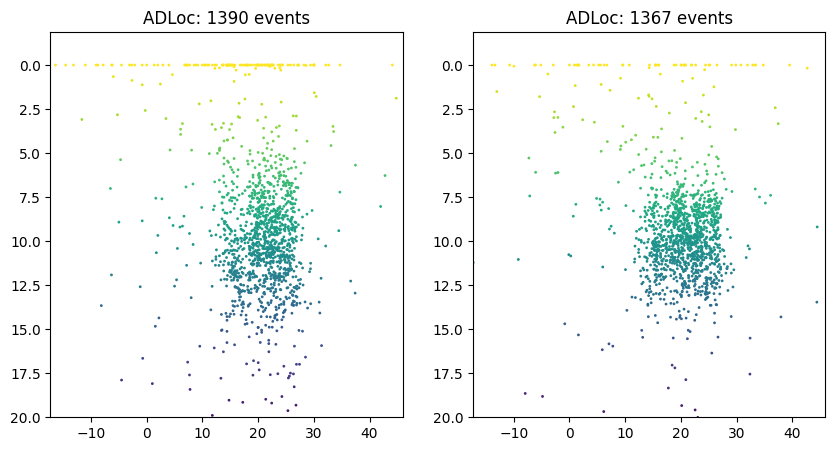

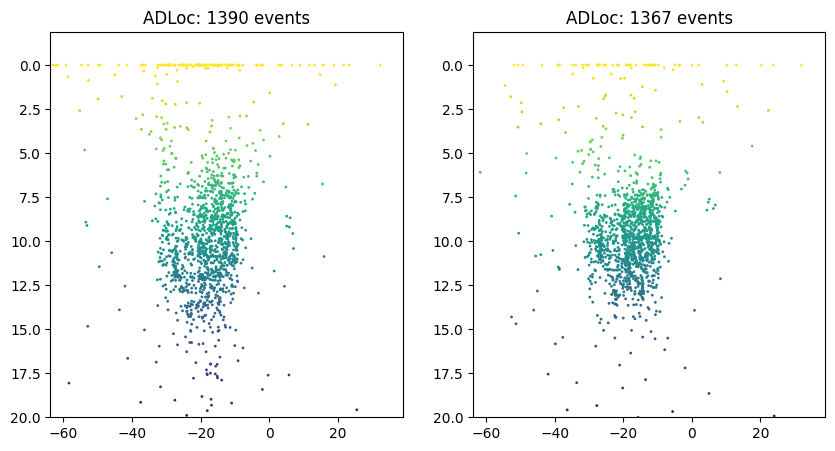

In [18]:
vmin = min(locations["z_km"].min(), events_old["depth_km"].min())
vmax = max(locations["z_km"].max(), events_old["depth_km"].max())
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(events_old["x_km"], events_old["y_km"], c=events_old["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.title(f"ADLoc: {len(events_old)} events")
plt.subplot(122)
plt.scatter(locations["x_km"], locations["y_km"], c=locations["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.title(f"ADLoc: {len(locations)} events")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(events_old["x_km"], events_old["z_km"], c=events_old["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([xmin, xmax])
plt.ylim([zmax, zmin])
plt.title(f"ADLoc: {len(events_old)} events")
plt.subplot(122)
plt.scatter(locations["x_km"], locations["z_km"], c=locations["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([xmin, xmax])
plt.ylim([zmax, zmin])
plt.title(f"ADLoc: {len(locations)} events")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(events_old["y_km"], events_old["z_km"], c=events_old["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([ymin, ymax])
plt.ylim([zmax, zmin])
plt.title(f"ADLoc: {len(events_old)} events")
plt.subplot(122)
plt.scatter(locations["y_km"], locations["z_km"], c=locations["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([ymin, ymax])
plt.ylim([zmax, zmin])
plt.title(f"ADLoc: {len(locations)} events")
plt.show()

In [19]:
station_term = picks[picks["mask"] == 1.0].groupby("idx_sta").agg({"residual_s": "mean"}).reset_index()
# np.mean(np.abs(station_term["residual_s"]))
stations['station_term_s'] += stations['idx_sta'].map(station_term.set_index('idx_sta')['residual_s']).fillna(0)

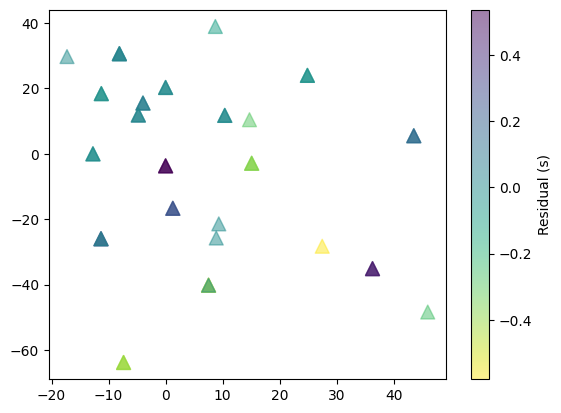

In [20]:
plt.figure()
plt.scatter(stations["x_km"], stations["y_km"], c=stations["station_term_s"], cmap="viridis_r", s=100, marker="^", alpha=0.5)
plt.colorbar(label="Residual (s)")
# plt.axis("scaled")